In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spam-emails-data-csv/spam_Emails_data.csv
/kaggle/input/xlnet/pytorch/xlnet-base-case/1/config.json
/kaggle/input/xlnet/pytorch/xlnet-base-case/1/tokenizer.json
/kaggle/input/xlnet/pytorch/xlnet-base-case/1/pytorch_model.bin


In [9]:
#  Install Required Libraries
!pip install transformers
!pip install tqdm
!pip install torch
!pip install transformers datasets scikit-learn
!pip install -q transformers datasets scikit-learn


In [4]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download('zoniaimran/spam-emails-data-csv')


In [10]:
import re
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from gensim.models import FastText
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, BatchNormalization, Dropout, Dense
from transformers import XLNetTokenizer, XLNetForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import ElectraTokenizer, ElectraForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from tqdm.notebook import tqdm
tqdm.pandas() 

In [6]:
# Step 1 data load
# Load the dataset
data = pd.read_csv('/kaggle/input/spam-emails-data-csv/spam_Emails_data.csv')

# Display the first 5 rows
print(data.head())




  label                                               text
0  Spam  viiiiiiagraaaa\nonly for the ones that want to...
1   Ham  got ice thought look az original message ice o...
2  Spam  yo ur wom an ne eds an escapenumber in ch ma n...
3  Spam  start increasing your odds of success & live s...
4   Ham  author jra date escapenumber escapenumber esca...


In [7]:
# Step 2 data preprocessing # Try specifying the delimiter explicitly (e.g., using a comma)
file_path = '/kaggle/input/spam-emails-data-csv/spam_Emails_data.csv'

# Try specifying the delimiter explicitly
data = pd.read_csv(file_path, sep=',', on_bad_lines='skip')  # or use on_bad_lines='warn'

# Total number of emails in the original dataset
total_emails = len(data)
print(f"Total number of emails in the dataset: {total_emails}")

# Drop rows with missing 'text'
data = data.dropna(subset=['text'])

# Preprocessing function
def preprocess_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text)         # Replace multiple spaces with single space
    text = text.strip()                      # Remove leading/trailing spaces
    text = text.lower()                      # Convert to lowercase
    return text

# Apply preprocessing
data['cleaned_text'] = data['text'].astype(str).apply(preprocess_text)

# Remove empty cleaned texts
data = data[data['cleaned_text'].str.strip() != ""]

# Tokenize the text
data['tokenized_text'] = data['cleaned_text'].apply(lambda x: x.split())

# Number of emails after preprocessing
preprocessed_emails = len(data)
print(f"Number of emails after preprocessing: {preprocessed_emails}")

Total number of emails in the dataset: 193852
Number of emails after preprocessing: 193752


Training FastText model...
FastText training completed in 834.60 seconds.


  0%|          | 0/193752 [00:00<?, ?it/s]

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
(20,)
Reducing dimensionality using PCA...
Generating plot...
0
[array([-2.212009  , -3.4216566 ,  0.13850251, -2.6402867 ,  2.7913442 ,
        2.270115  , -1.7251207 ,  1.1072383 ,  0.7674547 ,  0.7426622 ,
        2.756844  ,  1.5039262 ,  4.602725  , -1.8304935 ,  0.36846927,
        0.5603769 , -2.2403202 ,  0.3087808 ,  0.7277049 ,  0.80922025],
      dtype=float32)]


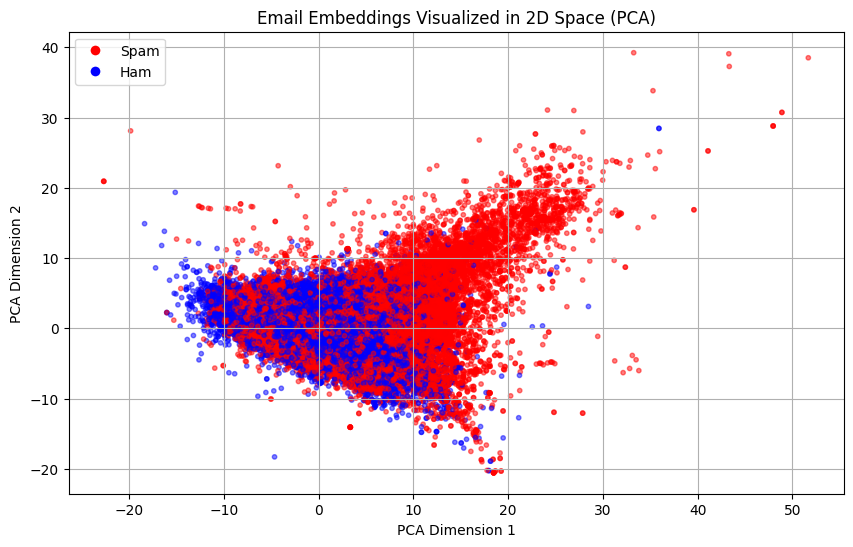

In [11]:
# Step 3  Train FastText Model
corpus = data['tokenized_text'].tolist()
print("Training FastText model...")
start_time = time.time()

fasttext_model = FastText(
    sentences=corpus,
    vector_size=20,  # Smaller dimension
    window=5,
    min_count=2,
    sg=0,  # CBOW
    workers=4,
    epochs=5
)

end_time = time.time()
print(f"FastText training completed in {end_time - start_time:.2f} seconds.")

# Generate Embeddings
def get_email_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

#  Apply to entire dataset
data['embedding'] = data['tokenized_text'].progress_apply(lambda x: get_email_embedding(x, fasttext_model))

#  Convert to NumPy array
X = np.vstack(data['embedding'].values)

#  Checks
print(type(data['embedding']))               # <class 'pandas.core.series.Series'>
print(type(data['embedding'].iloc[0]))       # <class 'numpy.ndarray'>
print(data['embedding'].iloc[0].shape)       # (20,)

# Reduce Dimensions with PCA
print("Reducing dimensionality using PCA...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

#  Visualization
print("Generating plot...")
plt.figure(figsize=(10, 6))

# Define colors: Spam (red), Ham (blue)
colors = {'Spam': 'red', 'Ham': 'blue'}
data['color'] = data['label'].map(colors)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['color'], alpha=0.5, s=10)
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.title("Email Embeddings Visualized in 2D Space (PCA)")

# Legend
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor='red', label='Spam'),
    plt.Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor='blue', label='Ham')
])

# Null check
print(data['embedding'].isnull().sum())  # Should be 0
print(data['embedding'].sample(1).tolist())  # Preview one embedding

plt.grid(True)
plt.show()

In [12]:

#  Step 4 XG Boost for feature selection
# Load Data (Ensure 'X' contains FastText embeddings & 'data["label"]' contains Spam/Ham labels)
y = data['label'].map({'Ham': 0, 'Spam': 1})

# Print Initial Data Info
print(f"Total Emails: {X.shape[0]}")
print(f"Initial Features: {X.shape[1]}")

# Train XGBoost Model for Feature Selection on the Complete Dataset
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X, y)

# Apply Feature Selection to the Entire Dataset
selector_xgb = SelectFromModel(xgb_model, prefit=True)
X_selected_xgb = selector_xgb.transform(X)

# Print Features After Selection
print(f"Features Selected by XGBoost: {X_selected_xgb.shape[1]} out of {X.shape[1]}")

# Split the Dataset After Feature Selection (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X_selected_xgb, y, test_size=0.2, random_state=42)

# Print Final Data Shapes
print(f"Training Data: {X_train.shape}, Testing Data: {X_test.shape}")

# Save Selected Features and Split Data for Future Use
np.save("/kaggle/working/X_train.npy", X_train)
np.save("/kaggle/working/X_test.npy", X_test)
np.save("/kaggle/working/y_train.npy", y_train)
np.save("/kaggle/working/y_test.npy", y_test)

# Success Message
print("Feature selection and train-test split complete. Data saved for ML/DL models.")



Total Emails: 193752
Initial Features: 20
Features Selected by XGBoost: 7 out of 20
Training Data: (155001, 7), Testing Data: (38751, 7)
Feature selection and train-test split complete. Data saved for ML/DL models.


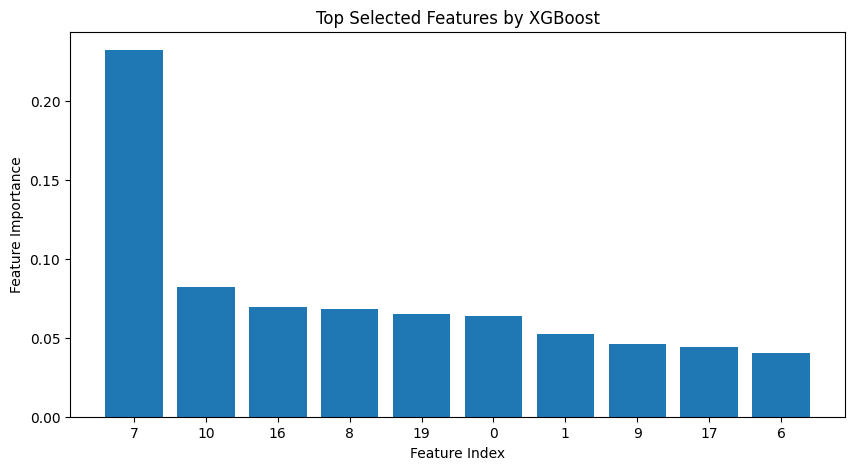

In [13]:
# show xg boost result in plot

# Get feature importance scores
feature_importance = xgb_model.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(feature_importance)[::-1]  # Highest to lowest

plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted_idx[:10])), feature_importance[sorted_idx[:10]], align="center")
plt.xticks(range(len(sorted_idx[:10])), sorted_idx[:10])  # Display feature indices
plt.xlabel("Feature Index")
plt.ylabel("Feature Importance")
plt.title("Top Selected Features by XGBoost")
plt.show()

In [14]:

# Step 5 Train LSTM model with improved architecture

# Load Preprocessed Dataset (Feature Selected)
X_train = np.load("/kaggle/working/X_train.npy")
X_test = np.load("/kaggle/working/X_test.npy")
y_train = np.load("/kaggle/working/y_train.npy")
y_test = np.load("/kaggle/working/y_test.npy")

# Print Dataset Shapes
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

# Reshape Data for LSTM (Adding Time Step Dimension)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # (samples, timesteps, features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define LSTM Model with more units and better architecture
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),  # Increased units
    BatchNormalization(),
    Dropout(0.3),  # Lower dropout to retain more information
    LSTM(256, return_sequences=True),  # Added another LSTM layer for better learning
    BatchNormalization(),
    LSTM(128),  # Reduce to 128 units after multiple layers for efficiency
    Dropout(0.3),
    Dense(256, activation='relu'),  # Increased Dense layer units
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # Binary Classification (Spam/Ham)
])

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train LSTM Model with a learning rate scheduler
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

# Train the model for more epochs and validation
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[reduce_lr])

# Predict on Test Set
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Convert Probabilities to 0/1

# Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print Evaluation Metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")


Training Data Shape: (155001, 7)
Testing Data Shape: (38751, 7)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
4844/4844 ━━━━━━━━━━━━━━━━━━━━ 195s 39ms/step - accuracy: 0.8625 - loss: 0.3171 - val_accuracy: 0.9146 - val_loss: 0.2068 - learning_rate: 0.0010
Epoch 2/20
4844/4844 ━━━━━━━━━━━━━━━━━━━━ 188s 39ms/step - accuracy: 0.9106 - loss: 0.2203 - val_accuracy: 0.9153 - val_loss: 0.2024 - learning_rate: 0.0010
Epoch 3/20
4844/4844 ━━━━━━━━━━━━━━━━━━━━ 188s 39ms/step - accuracy: 0.9158 - loss: 0.2077 - val_accuracy: 0.9192 - val_loss: 0.1956 - learning_rate: 0.0010
Epoch 4/20
4844/4844 ━━━━━━━━━━━━━━━━━━━━ 187s 39ms/step - accuracy: 0.9200 - loss: 0.1996 - val_accuracy: 0.9239 - val_loss: 0.1865 - learning_rate: 0.0010
Epoch 5/20
4844/4844 ━━━━━━━━━━━━━━━━━━━━ 196s 40ms/step - accuracy: 0.9206 - loss: 0.1965 - val_accuracy: 0.9233 - val_loss: 0.1891 - learning_rate: 0.0010
Epoch 6/20
4844/4844 ━━━━━━━━━━━━━━━━━━━━ 195s 40ms/step - accuracy: 0.9238 - loss: 0.1889 - val_accuracy: 0.9263 - val_loss: 0.1859 - learning_rate: 0.0010
Epoch 7/20
4844/4844 ━━━━━━━━━━━━━━━━━━━━ 190s 39ms/step -

In [ ]:
# Step 6 Train XLnet
# Load the pre-split .npy dataset
X_train = np.load("/kaggle/working/X_train.npy")
X_test = np.load("/kaggle/working/X_test.npy")
y_train = np.load("/kaggle/working/y_train.npy")
y_test = np.load("/kaggle/working/y_test.npy")

# ✅ Load the XLNet tokenizer from your uploaded folder
tokenizer = XLNetTokenizer.from_pretrained('/kaggle/input/xlnet/pytorch/xlnet-base-case/1')

# Tokenize train and test data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=256)

# Convert tokenized data into a dataset format
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'label': y_train.tolist()
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'label': y_test.tolist()
})

# ✅ Load the XLNet model from your uploaded folder
model = XLNetForSequenceClassification.from_pretrained(
    '/kaggle/input/xlnet/pytorch/xlnet-base-case/1',
    num_labels=2
)

# Define Training Arguments
training_args = TrainingArguments(
    output_dir='/kaggle/working',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/kaggle/working/logs',
    evaluation_strategy="epoch",
    load_best_model_at_end=True,
)

# Define function to compute metrics
def compute_metrics(p):
    predictions = p.predictions.argmax(axis=-1)
    accuracy = accuracy_score(p.label_ids, predictions)
    precision = precision_score(p.label_ids, predictions)
    recall = recall_score(p.label_ids, predictions)
    f1 = f1_score(p.label_ids, predictions)
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

In [ ]:
# Step 7 Train Electra 
# Load the .npy dataset
X_train = np.load("/kaggle/working/X_train.npy")  # Loaded train features
X_test = np.load("/kaggle/working/X_test.npy")    # Loaded test features
y_train = np.load("/kaggle/working/y_train.npy")  # Loaded train labels
y_test = np.load("/kaggle/working/y_test.npy")    # Loaded test labels

#  Tokenize Using ELECTRA Tokenizer
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

# Tokenize train and test data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=256)

#  Convert Data to PyTorch Datasets
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'label': y_train.tolist()
})
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'label': y_test.tolist()
})

#  Initialize ELECTRA Model for Sequence Classification
model = ElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator', num_labels=2)

#  Define Training Arguments
training_args = TrainingArguments(
    output_dir='/kaggle/working',           # Output directory
    num_train_epochs=3,                    # Number of training epochs
    per_device_train_batch_size=16,        # Batch size per device during training
    per_device_eval_batch_size=64,         # Batch size for evaluation
    warmup_steps=500,                      # Number of warmup steps
    weight_decay=0.01,                     # Strength of weight decay
    logging_dir='/kaggle/working/logs',    # Directory for storing logs
    evaluation_strategy="epoch",           # Evaluation strategy (evaluate after each epoch)
    load_best_model_at_end=True,           # Load the best model when finished training
)

#  Define Metrics Function
def compute_metrics(p):
    predictions = p.predictions.argmax(axis=-1)
    accuracy = accuracy_score(p.label_ids, predictions)
    precision = precision_score(p.label_ids, predictions)
    recall = recall_score(p.label_ids, predictions)
    f1 = f1_score(p.label_ids, predictions)
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

#  Initialize Trainer
trainer = Trainer(
    model=model,                            # ELECTRA model
    args=training_args,                     # Training arguments
    train_dataset=train_dataset,            # Training dataset
    eval_dataset=test_dataset,              # Evaluation dataset
    compute_metrics=compute_metrics         # Metric computation
)

#  Train the Model
trainer.train()

#  Evaluate the Model on Test Set
eval_results = trainer.evaluate()

#  Print Evaluation Results
print(f"Evaluation Results: {eval_results}")